In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.animation as animation

import scipy.signal as spsig
import h5py as h5
import itertools as itools
import functools as ftools

# logging, flow control and optimization
from logzero import logger
from tqdm.contrib.concurrent import process_map

# jwave imports
import jax.numpy as jnp
from jax import jit
from jwave import FourierSeries
from jwave.utils import show_field
import jax

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *

import Pulse as pulse
import plotutils as put
import sampling as lsmp # raytracing tools

%matplotlib widget

In [2]:
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update( 'jax_enable_x64', False )

E0728 11:04:38.347006   62307 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0728 11:04:38.347036   62307 cuda_dnn.cc:538] Memory usage: 8235057152 bytes free, 8500871168 bytes total.
E0728 11:04:38.347186   62307 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0728 11:04:38.347215   62307 cuda_dnn.cc:538] Memory usage: 8235057152 bytes free, 8500871168 bytes total.


In [3]:
print( jax.devices() )
print( jax.default_backend() )

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2)]
gpu


# User edit
You should not have to change anyting beyond the next cell. 

In [4]:
############## user edit #######################

simulation_result_file = 'SimulationsHere.h5'
padding_fraction = 0.1
num_points_along_largest_dimension = 1000

# # multiprocess parameters
# num_processes = 10

# can/cell details
soc = 0.3 # state of charge
can_thickness = 0.16
can_center = 21.5
transducer_dist = 10.
can_radius = 10.5
can_height = 70.
roll_inner_radius = 2.
cathode_location =  -135. # degrees
cathode_thickness = 0.13 
anode_thickness = 0.16
cathode_wrapping_sense = -1.

# crack details
add_crack=True 
crack_depth = 5.25 # mm
crack_size = 0.05 # mm

# Material properties (reference: https://www.sciencedirect.com/science/article/pii/S2352152X22006016)
# NOTE: Core is a fictitious material with the same acoustic impedance of air. 
# NOTE: water properties is substituted for electrolyte for now. 
# couplant is oil for now
materials = [ 'steel', 'couplant', 'roll', 'anode', 'electrolyte', 'cathode', 'core' ]
speeds = [ 5500., 1440., 1041.865, (1.-soc)*1341. + soc*1443., 1497., (1.-soc)*1093. + soc*1136., 3410. ]
densities = [ 7850., 870., 1933.949, (1.-soc)*1909. + soc*1994., 1000., (1.-soc)*4172. + soc*3848., 0.129 ] # jelly roll parameters for SOC = 0.3
reference_material = 'roll'

# pulse characteristics
center_frequency = 5.e6 # Hz
pulse_hg_order = 15 # order of the Hermite-Gauss pulse
simulation_time = 5.e-6 
c_mult = 0.05   # multiplier for max. Courant factor, to prevent diverging simulation. 


# transducer and pitch-catch geometry particulars
opening_angle = 60. # degrees
trans_dist_from_can = 3. # mm
num_elements = 32
element_size = 0.3 # mm
element_separation = 0.3 # mm

# display/visualization parameters
csf = 2. # color scale factor
frame_skip = 5
store_full_simulation = True # setting to True can fill up storage quite fast!
my_cmap = 'seismic'

################################################

# Stop!
Don't edit anything beyond this cell, unless you know what you're doing. 

# Custom functions

In [5]:
def GetMediumProperties( im, medium_dict ):
    def get_region( in_data ):
        return ( in_data[0]==in_data[1] )*in_data[2]
    sound_speed_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][0] ] )
            for idx in np.unique( im ).astype( int )
        ]
    )
    density_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][1] ] )
            for idx in np.unique( im ).astype( int )
        ]
    )
    return sound_speed_map, density_map

def World2Grid( point ):
    pout = np.array( [ np.round( ( point[n]-grid_ranges[n][0] )/( dx[n]*1.e3 ) ).astype( int ) for n in range( 2 ) ][::-1] )
    return pout

# Acoustic impedance and reflectivity

In [6]:
list( itools.combinations( materials, 2 ) )

[('steel', 'couplant'),
 ('steel', 'roll'),
 ('steel', 'anode'),
 ('steel', 'electrolyte'),
 ('steel', 'cathode'),
 ('steel', 'core'),
 ('couplant', 'roll'),
 ('couplant', 'anode'),
 ('couplant', 'electrolyte'),
 ('couplant', 'cathode'),
 ('couplant', 'core'),
 ('roll', 'anode'),
 ('roll', 'electrolyte'),
 ('roll', 'cathode'),
 ('roll', 'core'),
 ('anode', 'electrolyte'),
 ('anode', 'cathode'),
 ('anode', 'core'),
 ('electrolyte', 'cathode'),
 ('electrolyte', 'core'),
 ('cathode', 'core')]

In [7]:
material_properties = { key: [ val1, val2 ] for key, val1, val2 in zip( materials, speeds, densities ) }
reflectivity = { 
    key: ( np.prod( material_properties[ key[0] ] ) - np.prod( material_properties[ key[1] ] ) ) / ( np.prod( material_properties[ key[0] ] ) + np.prod( material_properties[ key[1] ] ) )
    for key in list( itools.combinations( materials, 2 ) )
}

In [8]:
material_properties

{'steel': [5500.0, 7850.0],
 'couplant': [1440.0, 870.0],
 'roll': [1041.865, 1933.949],
 'anode': [1371.6, 1934.5],
 'electrolyte': [1497.0, 1000.0],
 'cathode': [1105.8999999999999, 4074.7999999999993],
 'core': [3410.0, 0.129]}

In [9]:
reflectivity

{('steel', 'couplant'): 0.9436028792782897,
 ('steel', 'roll'): 0.9108246240556087,
 ('steel', 'anode'): 0.8842044450894404,
 ('steel', 'electrolyte'): 0.9329781518624641,
 ('steel', 'cathode'): 0.8109816928202526,
 ('steel', 'core'): 0.9999796231375466,
 ('couplant', 'roll'): -0.23322537632960863,
 ('couplant', 'anode'): -0.3585516538722605,
 ('couplant', 'electrolyte'): -0.0888064586515383,
 ('couplant', 'cathode'): -0.5649336312297029,
 ('couplant', 'core'): 0.9992979955338002,
 ('roll', 'anode'): -0.13676284394399266,
 ('roll', 'electrolyte'): 0.14747337437177244,
 ('roll', 'cathode'): -0.3820453501314744,
 ('roll', 'core'): 0.999563461234954,
 ('anode', 'electrolyte'): 0.27861682945012817,
 ('anode', 'cathode'): -0.2588049642744443,
 ('anode', 'core'): 0.9996684829413808,
 ('electrolyte', 'cathode'): -0.5012760702937019,
 ('electrolyte', 'core'): 0.9994124772514242,
 ('cathode', 'core'): 0.9998047866396721}

# Grid details

In [10]:
medium_dict = { 
    'couplant':0, 
    'steel':1, 
    'anode':2, 
    'roll':3, 
    'core':4, 
    'electrolyte':5
}
dict_medium = { val:key for key, val in medium_dict.items() }

buffer = 1. + padding_fraction
x_grid = buffer * np.linspace( -can_radius, can_radius, num_points_along_largest_dimension )
dx = ( x_grid[1:] - x_grid[:-1] ).mean()
y_grid = np.arange( -buffer*( can_radius/2. + transducer_dist ), 0., dx )
grid_ranges = [ x_grid,  y_grid ]
shp = ( grid_ranges[1].size, grid_ranges[0].size )
dy = ( y_grid[1:] - y_grid[:-1] ).mean() # y dimension is longer because of line source location
grid = np.meshgrid( x_grid,  y_grid )
dx_final = [ dx, dy ]
logger.info( f'Simulation domain size: {grid[0].shape}' )
logger.info( f'Pixel size: {dx_final} mm' )

pts = np.concatenate( [ ar.ravel()[np.newaxis,:] for ar in grid ], axis=0 )

rho = np.sqrt( ( pts**2 ).sum( axis=0 ) )
im_azim = medium_dict['couplant'] * np.ones( shp )
im_azim += medium_dict['steel'] * np.logical_and( rho <= can_radius, rho > can_radius-can_thickness ).reshape( shp )
im_azim +=  medium_dict['anode'] * np.logical_and( rho <= can_radius-can_thickness, rho > can_radius-can_thickness-anode_thickness ).reshape( shp )
im_azim +=  medium_dict['roll'] * np.logical_and( rho <= can_radius-can_thickness-anode_thickness, rho > roll_inner_radius ).reshape( shp )
im_azim += medium_dict['core'] * ( rho <= roll_inner_radius ).reshape( shp )
if add_crack: 
    crack_loc = np.array( [ 0., -( can_radius - crack_depth ) ] )
    rho_crack = np.sqrt( ( ( pts-crack_loc[:,np.newaxis].repeat( pts.shape[-1], axis=1 ) )**2 ).sum( axis=0 ) ) 
    # im_azim += medium_dict['electrolyte'] * ( rho_crack < crack_size ).reshape( shp ) # isotropic scatterer for now
    im_azim[ ( rho_crack < crack_size ).reshape( shp ) ] = medium_dict['electrolyte']


2025-07-28 11:04:38 - jwave [INFO]: Simulation domain size: (726, 1000)
2025-07-28 11:04:38 - jwave [INFO]: Pixel size: [0.023123123123123125, 0.023123123123124145] mm


# `jwave` definitions

## Cross section simulations

### Azimuthal

In [11]:
pml_size = np.round( buffer / dx_final[0] ).astype( int )//2
logger.info( f'PML size: {pml_size} pixels. ' )
speed_map, density_map = GetMediumProperties( im_azim, dict_medium )
dx = ( float( dx_final[1] )*1.e-3, float( dx_final[0] )*1.e-3 )
domain_azim = Domain( ( grid_ranges[1].size, grid_ranges[0].size ), dx )
speed_field = FourierSeries( jnp.expand_dims( speed_map, axis=-1 ), domain=domain_azim )
density_field = FourierSeries( jnp.expand_dims( density_map, axis=-1 ), domain=domain_azim )

medium = Medium(domain=domain_azim, sound_speed=speed_field, density=density_field, pml_size=int( pml_size ), attenuation=0.95 )

2025-07-28 11:04:38 - jwave [INFO]: PML size: 24 pixels. 


In [12]:
# show_field( speed_map )
# show_field( density_map )

## Time domain

2025-07-28 11:04:39 - jwave [INFO]: Dominant frequency: 5.000000e+06 Hz
2025-07-28 11:04:39 - jwave [INFO]: Dominant_wavelength: 2.08e-04 m
2025-07-28 11:04:39 - jwave [INFO]: Sample points per dominant wavelength: 9
2025-07-28 11:04:39 - jwave [INFO]: Dominant time period: 2.00e-07 sec
2025-07-28 11:04:39 - jwave [INFO]: Courant factor: 2.25e-01
2025-07-28 11:04:39 - jwave [INFO]: Time step: 9.47e-10 sec


Text(0.5, 1.0, 'Input pulse of fequency 5.00 MHz')

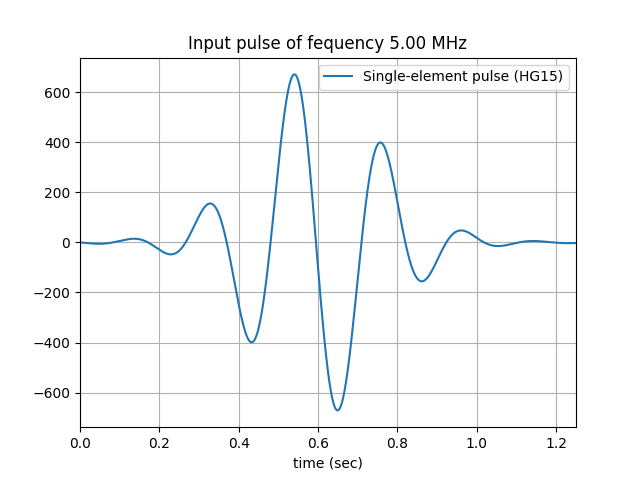

In [13]:
# calculating time-domain characteristics of pulse
center_wavelength = material_properties[ reference_material ][0] / center_frequency # pulse wavelength
period = 1. / center_frequency 
dx_dv_largest = dx_final[0]*1.e-3/ min( [ prop[0] for _, prop in material_properties.items() ] )
cfl_max = 0.5 * period / dx_dv_largest # courant number
cfl = cfl_max * c_mult

# time axis object
time_axis = TimeAxis.from_medium( medium, cfl=cfl )
time_axis.t_end = simulation_time # this is all we are currently measuring

# pulse details
# input_pulse = pd.read_csv( input_pulse_file )


logger.info( f'Dominant frequency: {center_frequency:2e} Hz' )
logger.info( f'Dominant_wavelength: {center_wavelength:.2e} m' )
logger.info( f'Sample points per dominant wavelength: {int(center_wavelength/(dx_final[0]*1.e-3))}' )
logger.info( f'Dominant time period: {period:.2e} sec' )
logger.info( f'Courant factor: {cfl:.2e}' )
logger.info( f'Time step: {time_axis.dt:.2e} sec' )

# craft the pulse of appropriate central frequency by modifying the frequency of a dummy pulse
spread = 5.e-6
test_grid = np.linspace( -5.*spread, 5.*spread, 600 )
init = pulse.HermiteGauss( test_grid, 0., spread, pulse_hg_order )
peaks = spsig.find_peaks( init )[0] # peak locations only 
T = ( test_grid[peaks[1:]] - test_grid[peaks[:-1]] ).mean() # approx. oscillation period of oscillating pulse
new_spread = spread * ( period / T ) # this is the correct HG input parameter for the desired ultrasound pulse frequency

t = np.arange( 0., float( time_axis.t_end ), float( time_axis.dt ) )
init = pulse.HermiteGauss( t, 3*new_spread, new_spread, pulse_hg_order )

plt.figure()
plt.plot( t/1.e-6, init, label=f'Single-element pulse (HG{pulse_hg_order})' )
plt.xlabel( 'time (sec)' ) 
plt.xlim( [ 0., simulation_time/4./1.e-6 ] )
plt.legend()
plt.grid()
plt.title( f'Input pulse of fequency {center_frequency/1.e6:.2f} MHz' )

# Set up simulation

## Sources and sensors

/tmp/ipykernel_62307/47624148.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


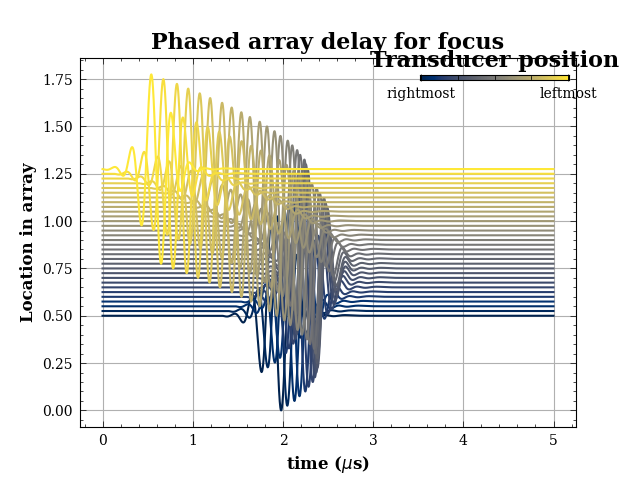

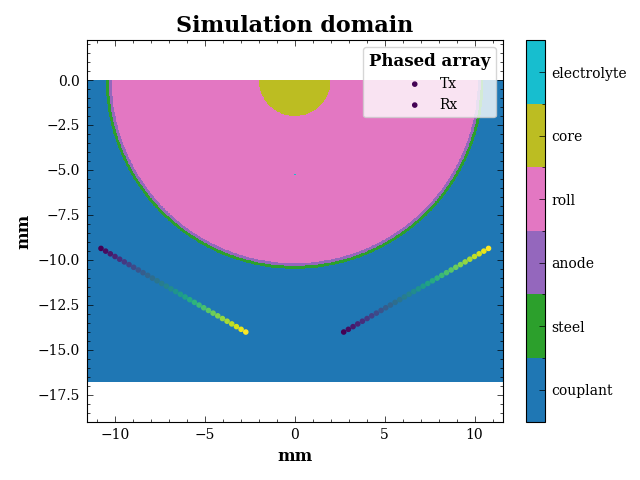

In [14]:
array_size = ( num_elements-1 ) * element_separation # mm
half_array = array_size/2. 
R = np.array( [ [ np.cos( np.pi/2. ), -np.sin( np.pi/2. ) ], [np.sin( np.pi/2. ), np.cos( np.pi/2. ) ] ] ) # 90 deg rotation matrix
    
# sources
arm_extend = can_radius + trans_dist_from_can
source_ang = -90. - opening_angle/2. 
source_array_position = np.array( [ arm_extend * fun( source_ang * np.pi/180. ) for fun in [ np.cos, np.sin ] ] )
looking_towards_core = -source_array_position/np.linalg.norm( source_array_position )
origin_src = source_array_position + R@( half_array*looking_towards_core ) 
direction_src = R.T @ looking_towards_core
locations_src = lsmp.SampleAlongLine( origin_src, direction_src, step_size=element_separation, num_steps=num_elements )
# now calculating Tx delays for incidence on crack
times = [ 
    dx[0]*lsmp.CalculateTimeOfFlight( 
        point_query=World2Grid( locations_src[:,n] ), 
        point_origin=crack_loc, 
        speed_map=speed_map, 
        steps_per_pixel=20 
    )[0] 
    for n in range( locations_src.shape[1] ) 
] # in seconds
times = [ max( times )-t for t in times ] # this is how much delay should be introduced
my_stack = [ init ] * locations_src.shape[1]
for n, ( deltaT, wav ) in enumerate( zip( times, my_stack ) ):
    delay_px = np.round( deltaT / time_axis.dt ).astype( int )
    my_stack[n] = np.roll( wav, delay_px )
plot_array = [ 0.025*n+( wav-wav.min() )/( wav.max()-wav.min() ) for n, wav in enumerate( my_stack ) ]
delays = np.argmax( 
    np.concatenate( [ ar[np.newaxis,:] for ar in plot_array ], axis=0 ), 
    axis=1
)
loc_px = [ list( World2Grid( locations_src[:,n] ) ) for n in range( locations_src.shape[1] )  ]
yloc, xloc = zip( *loc_px )
sources = Sources( 
    positions=( yloc, xloc ), 
    signals=jnp.stack( my_stack ),
    dt=time_axis.dt, 
    domain=domain_azim
)

# sensors
sensor_ang = -90. + opening_angle/2. 
sensor_array_position = np.array( [ arm_extend * fun( sensor_ang * np.pi/180. ) for fun in [ np.cos, np.sin ] ] )
looking_towards_core = -sensor_array_position/np.linalg.norm( sensor_array_position )
origin_tar = sensor_array_position + R@( half_array*looking_towards_core ) 
direction_tar = R.T @ looking_towards_core
locations_tar = lsmp.SampleAlongLine( origin_tar, direction_tar, step_size=element_separation, num_steps=num_elements )


################# plots ###################################################################

with plt.style.context( '/home/smaddali/Templates/custom.mplstyle' ):
    ax = put.PlotGraduatedData( 
        t/1.e-6, 
        plot_array, 
        value_range=[ -5., 5. ],
        title='Transducer position', 
        loc='upper right',
        llabel='rightmost', 
        rlabel='leftmost'
    )
    # ax.set_xlim( [ 0., 1.2 ] )
    ax.set_title( 'Phased array delay for focus', weight='bold' )
    ax.set_xlabel( 'time ($\\mu$s)' )
    ax.set_ylabel( 'Location in array' )

with plt.style.context( '/home/smaddali/Templates/custom.mplstyle' ):
    ax = put.PlotLabeledSegmentsImage( 
        im_azim, 
        segment_dictionary=dict_medium, 
        x_grid=grid_ranges[0], 
        y_grid=grid_ranges[1], 
        # alpha=0.5
    )
    ax.axis( 'equal' )
    ax.set_title( 'Simulation domain', weight='bold' )
    ax.set_xlabel( 'mm', weight='bold' )
    ax.set_ylabel( 'mm', weight='bold' )
    ax.scatter( locations_src[0], locations_src[1], c=list( range( locations_src.shape[1] ) ), marker='.', label='Tx' )
    ax.scatter( locations_tar[0], locations_tar[1], c=list( range( locations_tar.shape[1] ) ), marker='.', label='Rx' )
    ax.legend( title='Phased array' ).get_title().set_weight( 'bold' ) # matplotlib can't do this within custom style file for some reason...

plt.tight_layout()


In [ ]:
times = [ 
    dx[0]*lsmp.CalculateTimeOfFlight( 
        point_query=World2Grid( locations_src[:,n] ), 
        # point_origin=crack_loc, 
        point_origin=np.array( [ 0., 0. ] ), 
        speed_map=speed_map, 
        steps_per_pixel=20 
    )[0] 
    for n in range( locations_src.shape[1] ) 
] # in seconds

In [ ]:
plt.figure()
plt.plot( max( times ) - times )

# Sensors

In [ ]:
loc_px = [ list( World2Grid( locations_tar[:,n] ) ) for n in range( locations_tar.shape[1] )  ]
yloc, xloc = zip( *loc_px )

sensor_positions = ( xloc, yloc )
sensors = Sensors( positions=sensor_positions )

In [ ]:
if store_full_simulation: 
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources )
else: 
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources, sensors=sensors )


In [ ]:
pressure = compiled_simulator( sources )
pres = np.squeeze( pressure.on_grid ) if store_full_simulation else np.squeeze( pressure )
logger.info( f'Simulation size: {pres.shape}' )
pmax = min( np.abs( pres.min() ), np.abs( pres.max() ) )
pmin = -pmax

In [ ]:
print( pmin, pmax )

In [ ]:
# with h5.File( f'xloc_{array_xloc:.3f}_theta_{(cathode_location*180./np.pi):.3f}.h5', 'w' ) as fid: 
with h5.File( simulation_result_file, 'w' ) as fid: 
    fid.create_dataset( 'image', data=im_azim, compression='gzip', compression_opts=9 )
    if store_full_simulation:
        fid.create_dataset( 'pressure', data=pres[::frame_skip,:,:], compression='gzip', compression_opts=9 )
    else: # store only sensed waveforms
        fid.create_dataset( 'pressure', data=pres[::frame_skip,:], compression='gzip', compression_opts=9 ) 
    for key, val in {
        'x':grid_ranges[0], 
        'y':grid_ranges[1], 
        'delays':delays,
        'xloc':xloc, 
        'yloc':yloc, 
        'my_cmap':my_cmap, 
        'pmin':pmin, 
        'pmax':pmax,
        'csf':csf, 
        't':t[::frame_skip], 
        'time_steps':t[::frame_skip].size, 
        # 'focal_length':focal_length,
        'dt':time_axis.dt*frame_skip
    }.items():
        fid[ 'pressure' ].attrs[ key ] = val 
    for key, val in medium_dict.items(): 
        fid[ 'pressure' ].attrs[ f'medium_{val}' ] = key

# Visualization

In [ ]:
# my_cmap='hot'
# fig = plt.figure( figsize=( 14, 5 ) )
# ax = fig.subplots( 1, 2 )
# # extent=[ grid_ranges[0].min(), grid_ranges[0].max(), grid_ranges[1].min(), grid_ranges[1].max() ]
# ax[0].pcolormesh( np.arange( grid_ranges[0].size ), np.arange( grid_ranges[1].size ), im_azim, cmap=my_cmap, alpha=0.5 )
# # ax[0].imshow( im_azim, origin='lower', extent=extent, cmap=my_cmap, alpha=0.5 )
# fld = ax[0].imshow( pres[-1000,:,:], origin='lower', cmap='seismic' )
# ax[0].plot( xloc, yloc, '^k', markersize=2, label='Source' )
# fld.set_clim( [ pmin/csf, pmax/csf ] )
# ax[0].axis( 'equal' )ss
# ax[0].axis( 'square' )
# titl = ax[0].set_title( 'Pressure wave at time step 0' )
# ax[0].legend( loc='upper left' )

# ax[1].plot( t/1.e-6, pres[:,yloc,xloc].sum( axis=1 ) )
# ax[1].axis( 'tight' )
# ax[1].grid()
# ax[1].set_title( '2D pulse echo signal' )
# plt.suptitle( f'{string_handle} wave profile ({center_frequency/1.e6} MHz pulse)', weight='bold' )


# plt.tight_layout()
# # plt.show()

# def animate( n ):
#     fld.set_data( pres[n,yloc,xloc].sum( axis=1 ) )
#     fld.set_clim( [ pmin/csf, pmax/csf ] )
#     titl.set_text( f'Pressure wave at time {(n*time_axis.dt/1.e-6):.2e} us' )
#     return fld,

# ani = animation.FuncAnimation( fig, animate, interval=10, frames=pres.shape[0], blit=False, repeat=False )
# plt.show()
